In [1]:
import importlib
from pathlib import Path
from typing import Optional
from typing import Tuple, Dict

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader

from meningioma_dl.config import Config
from meningioma_dl.data_loading import data_loader
from meningioma_dl.data_loading.data_loader import (
    TransformationsMode,
)

import math
from monai import transforms
from typing import List

from meningioma_dl.visualizations.images_visualization import visualize_images

## Load config

In [7]:
# Config.load_env_variables("../envs/ci_run.env", "jupyter")

## Create Data Loader

In [2]:
from meningioma_dl.experiments_specs.preprocessing_specs import PreprocessingSpecs


def get_data_loader(
    transformations_mode: TransformationsMode,
    preprocessing_specs: PreprocessingSpecs,
    validation_set: bool,
) -> DataLoader:
    importlib.reload(data_loader)

    augmentation_settings: List[transforms.Transform] = []
    if transformations_mode.value == TransformationsMode.AUGMENT.value:
        probability = 0.2
        affined_translate = 8
        augmentation_settings = [
            transforms.RandStdShiftIntensityd(
                keys=["img"], factors=0.1, prob=probability + 0.1
            ),
            transforms.RandGaussianNoised(keys=["img"], prob=probability, std=0.2),
            # We need to mask after gaussian to avoid adding noise to the empty parts
            transforms.MaskIntensityd(keys=["img"], mask_key="mask"),
            transforms.RandRotated(
                keys=["img", "mask"],
                prob=probability + 0.05,
                range_x=math.pi / 4,
                range_y=math.pi / 4,
                range_z=math.pi / 4,
                padding_mode="zeros",
                keep_size=False,
            ),
            transforms.RandZoomd(
                keys=["img", "mask"],
                min_zoom=0.8,
                max_zoom=1.2,
                prob=probability,
                keep_size=False,
            ),
            transforms.RandFlipd(
                keys=["img", "mask"], spatial_axis=0, prob=probability
            ),
            transforms.RandFlipd(
                keys=["img", "mask"], spatial_axis=1, prob=probability + 0.05
            ),
            transforms.RandFlipd(
                keys=["img", "mask"], spatial_axis=2, prob=probability
            ),
            # transforms.Rand3DElasticd(
            #     keys=["img", "mask"],
            #     sigma_range=(0, 1),
            #     magnitude_range=(3, 6),
            #     prob=1.0,
            #     rotate_range=(np.pi / 4),
            #     padding_mode="zeros",
            # ),
            transforms.RandAffined(
                keys=["img", "mask"],
                translate_range=[
                    (-affined_translate, affined_translate),
                    (-affined_translate, affined_translate),
                    (-affined_translate, affined_translate),
                ],
                prob=probability + 0.05,
                padding_mode="zeros",
            ),
        ]

    labels_file = (
        Config.validation_labels_file_path
        if validation_set
        else Config.train_labels_file_path
    )
    training_data_loader, _ = data_loader.get_data_loader(
        labels_file,
        Config.data_directory,
        transformations_mode=transformations_mode,
        batch_size=1,
        augmentations=augmentation_settings,
        preprocessing_specs=preprocessing_specs,
    )
    return training_data_loader


# training_data_loader = get_data_loader(TransformationsMode.ONLY_PREPROCESSING)
# data_loader_iter = iter(training_data_loader)
# number_of_samples = len(training_data_loader)
# first_sample = next(data_loader_iter)

## Basic visualization

In [3]:
def visualize_transformations(
    training_data_loader, transformations_name: str, show_mask: bool = True
):
    dir = Path(".", "data", transformations_name)
    dir.mkdir(parents=True, exist_ok=False)
    max_bounding_box = 0

    try:
        for i, d in enumerate(training_data_loader):
            print(f"Image {i}")
            filename = Path(d["img_meta_dict"]["filename_or_obj"][0]).stem.split(".")[0]
            visualize_images(
                d["img"], dir, [f"{filename}_label_{d['label'][0].data+1}_img"]
            )
            print(f"Image shape: {d['img'].shape}")
            bounding_box = max(d["img"].shape)
            if bounding_box > max_bounding_box:
                max_bounding_box = bounding_box
            if show_mask:
                visualize_images(
                    d["mask"], dir, [f"{filename}_label_{d['label'][0].data+1}_mask"]
                )
    except:
        dir.rmdir()
        raise
    finally:
        print(f"max dimension: {max_bounding_box}")


# visualize_transformations(get_data_loader(TransformationsMode.AUGMENT), "test2")

Image 0
Image shape: torch.Size([1, 1, 24, 22, 20])
Image 1
Image shape: torch.Size([1, 1, 51, 55, 46])
max dimension: 55


OSError: [WinError 145] The directory is not empty: 'data\\train_only_load_2'

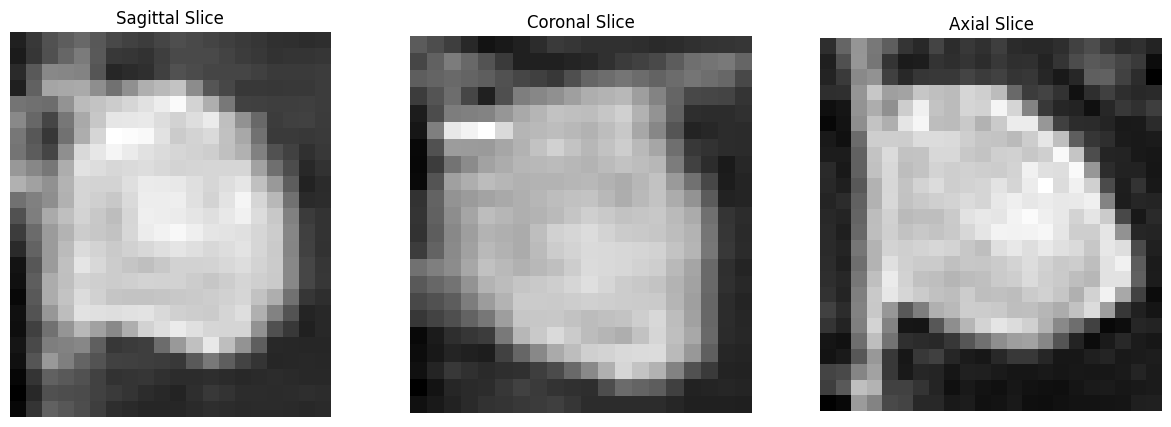

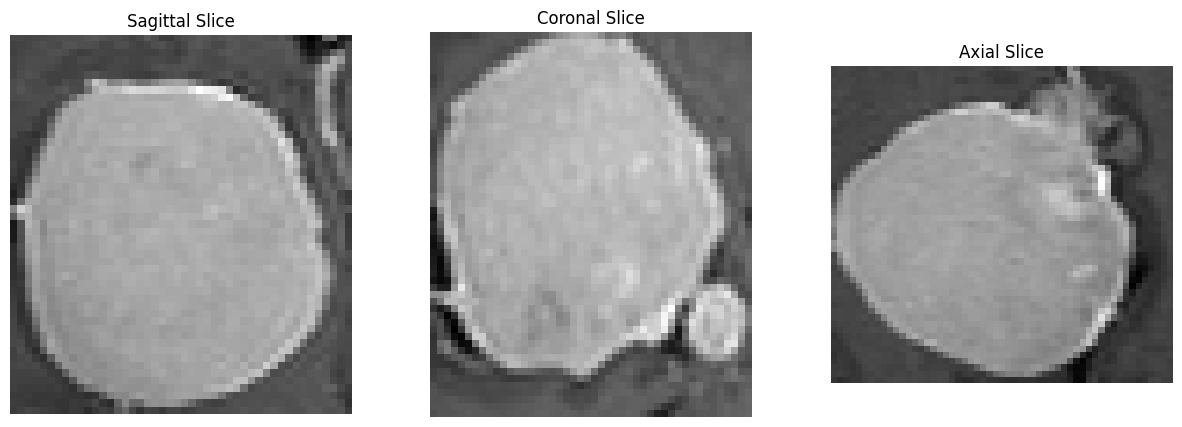

In [6]:
from meningioma_dl.experiments_specs import experiments

importlib.reload(experiments)

Config.load_env_variables("../envs/local_run_cluster_data.env", "jupyter")
plt.ioff()
transformations_name = "train_only_load_2"
visualize_transformations(
    get_data_loader(
        TransformationsMode.ONLY_LOAD,
        # PreprocessingSettings(final_crop_and_pad_spatial_size=None, final_resize_mode=None),
        experiments.PreprocessingSpecs.get_from_name("no_resize"),
        validation_set=False,
    ),
    transformations_name,
    show_mask=False,
)

In [ ]:
from collections import defaultdict
from typing import Sequence
from reportlab.platypus import SimpleDocTemplate, Image, Paragraph, PageBreak
from PIL import Image as PILImage

base_path = Path(".", "data")
pdf_file = base_path.joinpath(f"{transformations_name}.pdf")
images = list(base_path.joinpath(transformations_name).glob("*img.png"))


def create_pdf_from_images(images: Sequence[Path], pdf_file: Path):
    images_by_label = defaultdict(list)
    for image in images:
        label = image.stem.split("_")[-2]
        images_by_label[label].append(image)

    doc = SimpleDocTemplate(
        str(pdf_file), rightMargin=0, leftMargin=0, topMargin=0, bottomMargin=0
    )

    elements = []
    for label, images_with_label in sorted(images_by_label.items()):
        elements.append(Paragraph(f"Label {label}"))
        for file in images_with_label:
            image = PILImage.open(file)

            # Resize the image to fit the page width
            if image.width > doc.width or image.height > doc.height:
                image.thumbnail((doc.width, doc.height), PILImage.LANCZOS)
            elements.append(Image(str(image.filename), image.width, image.height))
        elements.append(PageBreak())

    doc.build(elements)


create_pdf_from_images(images, pdf_file)

## Get the biggest bounding box in the dataset

First, you need to customize data loader to only make cropping

In [136]:
def get_max_bounding_box(data_loader: DataLoader) -> Tuple[np.array, ...]:
    bounding_boxes = []
    i = 0
    labels = []
    for data in data_loader:
        bounding_boxes.append(
            (data["foreground_start_coord"], data["foreground_end_coord"])
        )
        labels.append(data["label"])
        i += 1
        print(i)

    print(bounding_boxes)
    centers = []
    sizes = []
    max_length = 0
    for box in bounding_boxes:
        box_size = box[1] - box[0]
        centers.append(box[0] + box_size / 2.0)
        sizes.append(box[1] - box[0])
        max_length_box = box_size.max()
        if max_length_box > max_length:
            max_length = max_length_box
    return np.array([max_length] * 3), centers, sizes, labels


loader = get_data_loader(TransformationsMode.ONLY_PREPROCESSING, ci_run=False)
max_bounding_box, centers, sizes, labels = get_max_bounding_box(loader)

yes
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
[(tensor([[126,  96,  38]], dtype=torch.int32), tensor([[181, 147,  92]], dtype=torch.int32)), (tensor([[83, 94, 21]], dtype=torch.int32), tensor([[107, 116,  39]], dtype=torch.int32)), (tensor([[76, 80, 20]], dtype=torch.int32), tensor([[128, 128,  74]], dtype=torch.int32)), (tensor([[63, 83, 31]], dtype=torch.int32), tensor([[113, 125,  77]], dtype=torch.int32)), (tensor([[ 68, 111,  23]], dtype=torch.int32), tensor([[ 87, 130,  37]], dtype=torch.int32)), (tensor([[ 28, 144,  55]], dtype=torch.int32), tensor([[ 69, 193, 

## Visualization of bounding boxes

In [137]:
def reshape_list_of_tensors(list_of_tensors):
    stacked_array = np.stack(list_of_tensors)
    return stacked_array.reshape(len(list_of_tensors), -1)


centers_reshaped = reshape_list_of_tensors(centers)
labels_reshaped = reshape_list_of_tensors(labels)

In [138]:
import plotly.express as px

df = pd.DataFrame(
    {
        "x": centers_reshaped[:, 0],
        "y": centers_reshaped[:, 1],
        "z": centers_reshaped[:, 2],
        "labels": labels_reshaped[:, 0],
    }
)
fig = px.scatter_3d(df, x="x", y="y", z="z", color="labels")
fig.show()
# fig.write_html("locations_distribuition.html")
# plot_3d_density(centers, labels)

In [152]:
import plotly.express as px

sizes_reshaped = reshape_list_of_tensors(sizes)
df = pd.DataFrame(
    {
        "volume": sizes_reshaped[:, 0] * sizes_reshaped[:, 1] * sizes_reshaped[:, 2],
        "labels": labels_reshaped[:, 0],
    }
)
# Create the distribution plot using Plotly Express
fig = px.histogram(
    df,
    x="volume",
    color="labels",
    marginal="rug",
    histnorm="probability",
    title="Distribution of volumes by class",
)

# Show the plot
fig.show()
fig.write_html("sizes_distribuition.html")
# plot_3d_density(centers, labels)

## Crop image by mask

In [52]:
def find_bounding_box(image_array: np.array) -> Tuple[np.array, np.array]:
    indices = np.argwhere(image_array == 1)
    min_indices = np.min(indices, axis=0)
    max_indices = np.max(indices, axis=0) + 1
    return min_indices, max_indices


def crop_image_by_mask(
    data_dict: Dict[str, np.array], output_size: Optional[np.array] = None
) -> Tuple[Dict[str, np.array], Tuple[np.array]]:
    assert data_dict["img"].ndim == data_dict["mask"].ndim
    mask_image_array = data_dict["mask"]
    bounding_box = find_bounding_box(mask_image_array)
    # print(bounding_box)

    # TODO how to do it for batches?
    roi_center = bounding_box[0] + (bounding_box[1] - bounding_box[0]) // 2
    if output_size is None:
        output_size = bounding_box[1] - bounding_box[0]

    # TODO move if away from image
    lower_indeces = (roi_center - np.floor(output_size / 2)).astype(int)
    higher_indeces = (roi_center + np.ceil(output_size / 2)).astype(int)
    # print(roi_center)
    # print(output_size)
    # print(lower_indeces)
    # print(higher_indeces)

    slices = tuple(
        slice(lower_indeces[i], higher_indeces[i]) for i in range(mask_image_array.ndim)
    )
    # print(slices)

    return data_dict["img"][slices], bounding_box


def test_crop_image():
    data_dict = {
        "img": np.array([[1, 2, 3, 4], [5, 6, 7, 8], [9, 10, 11, 12]]),
        "mask": np.array([[1, 0, 0, 0], [0, 0, 0, 0], [1, 1, 0, 0]]),
    }
    expected_cropped_img = np.array([[1, 2], [5, 6], [9, 10]])
    expected_bounding_box = [np.array([0, 0]), np.array([3, 2])]
    cropped_img, bounding_box = crop_image_by_mask(data_dict, output_size=None)

    print(bounding_box)
    np.testing.assert_equal(expected_cropped_img, cropped_img)
    np.testing.assert_equal(expected_bounding_box, bounding_box)


# test_crop_image()

# cropped_img, bounding_box = crop_image_by_mask(copy.deepcopy(data), None) # np.array([1,1,200,200,200])
# # visualize_image(cropped_img)
# cropped_img.shape

torch.Size([1, 1, 0, 0, 35])